In [3]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
import shap

In [4]:
# Utiliser le répertoire de travail actuel comme base si __file__ ne fonctionne pas
base_path = Path(os.getcwd())  # Utilisation du répertoire de travail actuel

# Définir le chemin vers le dossier contenant les fichiers zippés
data_path = base_path / '../Data'

# Liste des fichiers à charger
files = {
    'X_train': 'X_train.zip',
    'X_test': 'X_test.zip',
    'y_train': 'y_train.zip',
    'y_test': 'y_test.zip'
}

# Dictionnaire pour stocker les données chargées
data = {}

for key, file_name in files.items():
    file_path = data_path / file_name  # Utilisation de Path pour concaténer le chemin
    try:
        # Charger le fichier CSV compressé en DataFrame
        data[key] = pd.read_csv(file_path, compression='zip')
        print(f"{key} chargé avec succès.")
    except Exception as e:
        print(f"Erreur lors du chargement de {file_name}: {e}")

# Attribution des données aux variables
X_train = data.get('X_train')
X_test = data.get('X_test')
y_train = data.get('y_train')
y_test = data.get('y_test')

# Vérification des dimensions des données
print("\nDimensions des données chargées :")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train chargé avec succès.
X_test chargé avec succès.
y_train chargé avec succès.
y_test chargé avec succès.

Dimensions des données chargées :
X_train: (352893, 337)
X_test: (88224, 337)
y_train: (352893, 1)
y_test: (88224, 1)


In [5]:
# Fusionner les classes 0 et 1 en 0, et les classes 2 et 3 en 1
y_train = y_train.replace({0: 0, 1: 0})  # Fusionner 0 et 1 en 0
y_train = y_train.replace({2: 1, 3: 1})  # Fusionner 2 et 3 en 1

y_test = y_test.replace({0: 0, 1: 0})    # Fusionner 0 et 1 en 0
y_test = y_test.replace({2: 1, 3: 1})    # Fusionner 2 et 3 en 1

# Vérification des classes après fusion
print(f"Classes dans y_train après fusion: {y_train.value_counts()}")
print(f"Classes dans y_test après fusion: {y_test.value_counts()}")

# Vérification des dimensions de X_train et X_test
print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de X_test : {X_test.shape}")

Classes dans y_train après fusion: grav
0       287811
1        65082
Name: count, dtype: int64
Classes dans y_test après fusion: grav
0       71781
1       16443
Name: count, dtype: int64
Dimensions de X_train : (352893, 337)
Dimensions de X_test : (88224, 337)


In [6]:
# Définir un pipeline avec undersampling et oversampling
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),  # Réduire la classe majoritaire
    ('oversample', SMOTE(random_state=42))  # Augmenter la classe minoritaire
])
# Application du pipeline sur X_train et y_train
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Convertir y_train_resampled en numpy array et aplatir en 1D
y_train_resampled = y_train_resampled.to_numpy().flatten()

# Vérification de la distribution après rééquilibrage
print("Distribution des classes après rééquilibrage :")
print(pd.Series(y_train_resampled).value_counts())

# Vérification des dimensions après rééquilibrage
print(f"Dimensions après rééquilibrage : X_train = {X_train_resampled.shape}, y_train = {y_train_resampled.shape}")

Distribution des classes après rééquilibrage :
0    130164
1    130164
Name: count, dtype: int64
Dimensions après rééquilibrage : X_train = (260328, 337), y_train = (260328,)


In [7]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)

# Normalisation de X_test
X_test = scaler.transform(X_test)

In [8]:
# Calcul des poids des classes pour compenser le déséquilibre des classes
class_weights_dict = {0: 0.5, 1: 3}  # Augmenter le poids de la classe minoritaire

# Architecture améliorée avec plus de couches et une meilleure régularisation
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sortie binaire
])

model.compile(optimizer=Adam(learning_rate=0.0005),  # Utiliser un taux d'apprentissage plus faible
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall"),
                       tf.keras.metrics.AUC(name="auc")])


In [9]:
# Callback pour un arrêt anticipé
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback pour un scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# Callback pour ajuster dynamiquement le taux d'apprentissage
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [10]:
# Entraînement du modèle avec les callbacks et les poids de classes
history = model.fit(
    X_train_resampled, y_train_resampled,  # Utilisation des données équilibrées
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,  # Poids des classes
    callbacks=[early_stopping, lr_scheduler, reduce_lr]
)

Epoch 1/50
6509/6509 [==============================] - 36s 5ms/step - loss: 0.5217 - accuracy: 0.6621 - precision: 0.5273 - recall: 0.9541 - auc: 0.8492 - val_loss: 0.1496 - val_accuracy: 0.9683 - val_precision: 1.0000 - val_recall: 0.9683 - val_auc: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/50
6509/6509 [==============================] - 34s 5ms/step - loss: 0.4872 - accuracy: 0.6896 - precision: 0.5494 - recall: 0.9577 - auc: 0.8700 - val_loss: 0.1324 - val_accuracy: 0.9720 - val_precision: 1.0000 - val_recall: 0.9720 - val_auc: 0.0000e+00 - lr: 5.0000e-04
Epoch 3/50
6509/6509 [==============================] - 31s 5ms/step - loss: 0.4752 - accuracy: 0.6976 - precision: 0.5562 - recall: 0.9587 - auc: 0.8765 - val_loss: 0.1332 - val_accuracy: 0.9678 - val_precision: 1.0000 - val_recall: 0.9678 - val_auc: 0.0000e+00 - lr: 5.0000e-04
Epoch 4/50
6509/6509 [==============================] - 35s 5ms/step - loss: 0.4644 - accuracy: 0.7030 - precision: 0.5608 - recall: 0.9601 - auc: 0.8818 - val_

In [11]:
# Définir un seuil
threshold = 0.6
# Prédictions du modèle
y_pred_probs = model.predict(X_test)
# Appliquer le seuil pour obtenir les prédictions finales (0 ou 1)
y_pred = (y_pred_probs > threshold).astype(int)

# Calcul des métriques de performance
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Rapport de classification (precision, recall, f1-score)
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

# Précision globale du modèle
print("\nPrécision : {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


2757/2757 [==============================] - 5s 2ms/step
Matrice de confusion :
 [[51275 20506]
 [ 2036 14407]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     71781
           1       0.41      0.88      0.56     16443

    accuracy                           0.74     88224
   macro avg       0.69      0.80      0.69     88224
weighted avg       0.86      0.74      0.77     88224


Précision : 74.45%


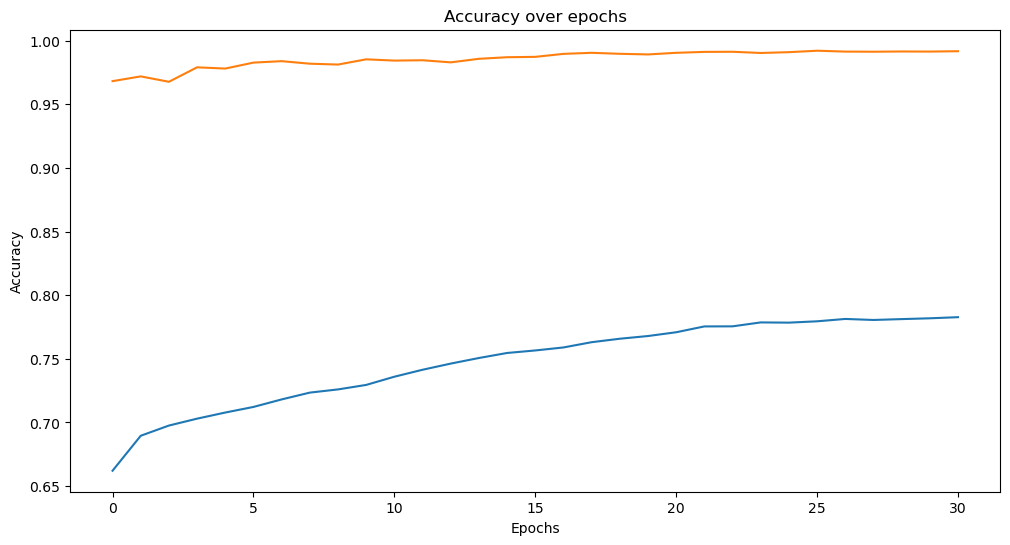

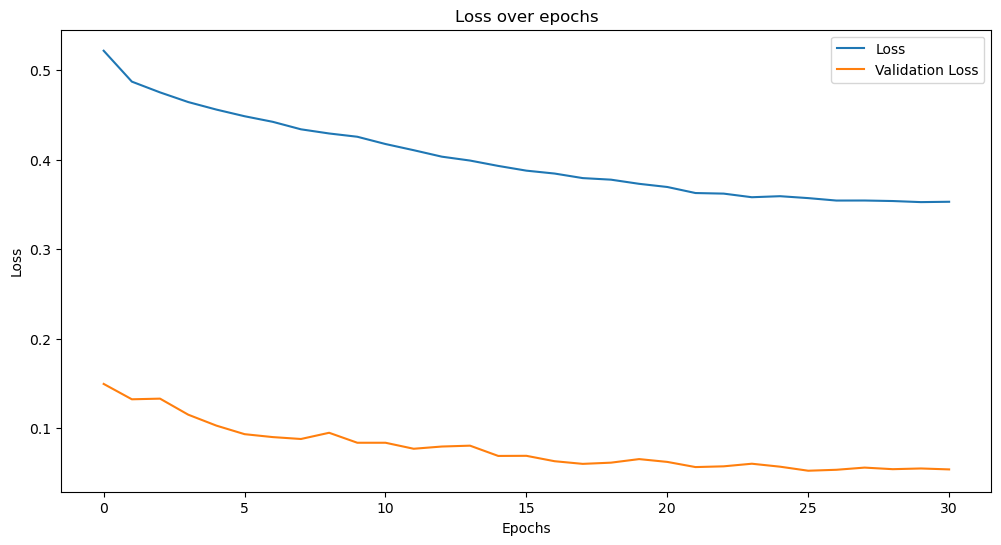

In [12]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
import os
from joblib import dump

# Définir le chemin relatif pour le dossier 'results' dans le répertoire actuel
result_dir = os.path.join(os.getcwd(), "results")

# Chemin complet pour le fichier du modèle
model_path = os.path.join(result_dir, "2class_neural_network_model.joblib")

# Sauvegarde du modèle avec joblib
try:
    dump(model, model_path)
    print(f"Modèle enregistré avec succès dans : {model_path}")
except Exception as e:
    print(f"Erreur lors de l'enregistrement du modèle : {e}")

INFO:tensorflow:Assets written to: ram://9a139838-6336-4d39-8915-fc3dfeff0fa4/assets
Modèle enregistré avec succès dans : C:\Users\Victor\Documents\Projet_accident\neural_network\results\2class_neural_network_model.joblib
